# Часть 1. k-Nearest Neighbor (kNN) классификатор

kNN классификатор:
- Во время обучения получает данные и просто запоминает их
- Во время тестирования каждое тестовое изображение сравнивается с каждым обучающим. Итоговая метка получается на основе анализа меток k ближайших обучающих изображений
- Значение k подбирается с помощью кросс-валидации.

Первое упражнение разминочное. Направлено на поминимание pipeline классификации изображений, кросс-валидации и получения практики написания эффективного векторизованного кода, осознания его эффективности.

In [23]:
# Run some setup code for this notebook.
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


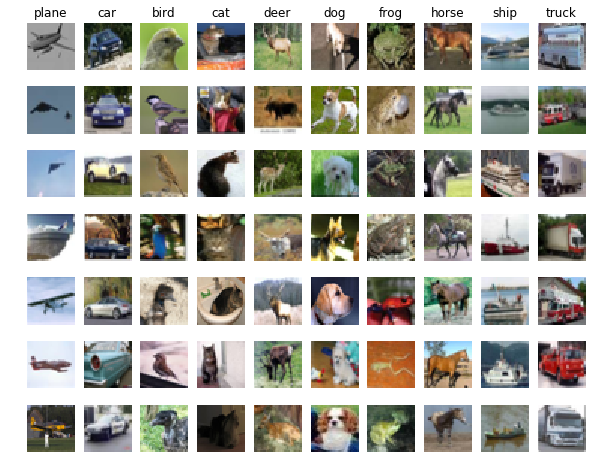

In [25]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [26]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [27]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [28]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Нам хочется классифицировать данные с помощью kNN. Вспомним, что этот процесс можно разбить на 2 шага:

1. Посчитать расстояние между каждым обучающим и каждым тестовым примером.
2. Имея эти расстояния для каждого тестового примера найти k ближайших примеров и дать им проголосовать за итоговую метку.

Начать стоит с подсчета матрицы расстояний между всеми обучающими и всеми тестовыми примерами. Например, если у вас **Ntr** обучающих примеров и **Nte** тестовых примеров, то на этом этапе у вас должна получиться матрица из **Nte x Ntr** элементов, где элемент (i, j) равен расстоянию от i-ого обучающего до j-ого тестового примера.

Откройте файл `cs231n/classifiers/k_nearest_neighbor.py` и реализуйте в нём функцию `compute_distances_two_loops`, используя (крайне неэффективный) вложенный цикл по всем парам из (test, train), подсчитывая по одному элементу матрицы да одну итерацию.

In [29]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


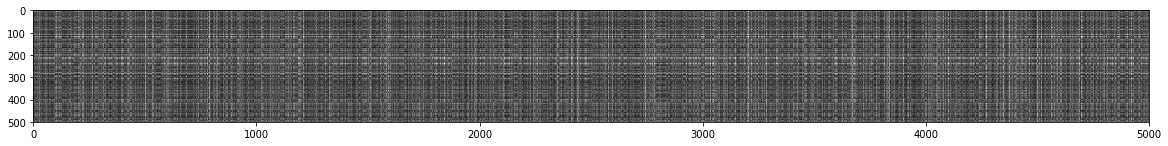

In [30]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.figure(figsize=(20, 20))
plt.imshow(dists, interpolation='none')
plt.show()

**Вопрос №1** Обратите внимание на структурные элементы в матрице расстояний. Какие-то строки и столбцы являются более яркими. (При этом в цветовой схеме по умолчанию чёрный свет соответсвует малым расстояниям, а белый - большим.)

- Что именно в данных приводит к тому, что некоторые строчки отчётливо яркие?
- А столбцы?

**Ваш ответ**: Яркость строки или столбца <= большое расстояние до всех остальных изображений (тестовой/обучающей выборки соответственно) <= такие изображения очень мало похожи на остальные и возможно они являются выбросами. Чем именно это может быть вызвано на уровне пикселей - не могу предположить.


Далее нужно реализовать функцию `
predict_labels`, и запустить следующий код. Получим accuracy для `k = 1`

In [31]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


Должно получится где-то `27%` accuracy. Теперь попробуем большее значение `k`, например `k = 5`:

In [32]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


Должно стать немного лучше, чем с `k = 1`.

**Вопрос №2**

Можно также попробовать другую метрику расстояний, например L1.
Качество классификатора по ближайшемоу соседу с L1 расстоянием не изменится, если (Выберите все подходящие варианты):
1. Данные предобработаны вычитанием среднего.
2. Данные предобработаны вычитанием среднего и делением на дисперсию.
3. Координатные оси данных повёрнуты.
4. Ни одно из вышеперечисленного.

*Ваш ответ*:

*Ваше объяснение*:

Теперь нужно немного ускорить подсчёт матрицы расстояний, ограничив число циклов до одного. Реализуйте функцию `compute_distances_one_loop` и запустите код ниже

In [33]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Наконец реализуем полностью векторизованную версию: `compute_distances_no_loops`

In [34]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Осталось сравнить эффективность всех 3 написанных версий

In [35]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 48.247461 seconds
One loop version took 36.931639 seconds
No loop version took 0.371575 seconds


### Cross-validation

Мы построили классификатор, используя k = 5 по умолчанию. Теперь подберём оптимальное значение гиперпараметра с использованием кросс-валидации методом k-fold. Требуется разбить ваши данные на группы (folds) и для каждой группы посчитать accuracy, когда она выделяется как тестовая.

In [36]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50]

X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
best_val = -1.0
best_k = -1

for k in k_choices:
    k_to_accuracies[k] = []
    for test_index in range(num_folds):
        train_fold_indecies = [i for i in range(num_folds) if i != test_index]
        trainX = np.concatenate(X_train_folds[train_fold_indecies])
        trainY = np.concatenate(y_train_folds[train_fold_indecies])
        classifier = KNearestNeighbor()
        classifier.train(trainX, trainY)
        num_test = len(X_train_folds[test_index])
        pred = classifier.predict(X_train_folds[test_index], k)
        num_correct = np.sum(pred == y_train_folds[test_index])
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k].append(accuracy)
        if accuracy > best_val:
            best_val = accuracy
            best_k = k

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

print("Best val accuracy is %f for k=%d", (best_val, best_k))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

Построим график зависимости качества от k

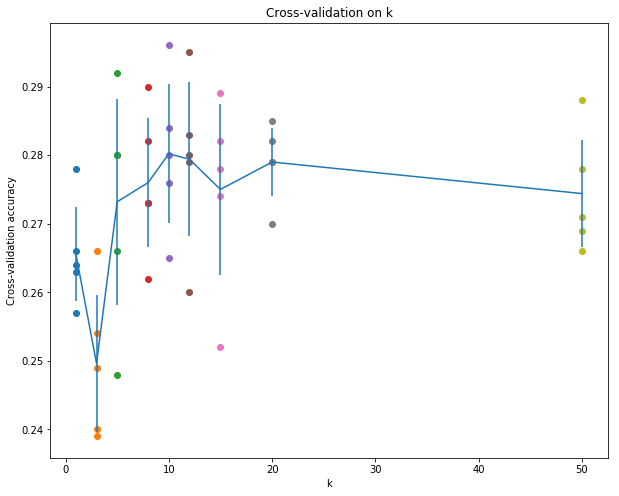

In [37]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

Наконец, выберите лучшее значение k и переобучите классификатор с использованием всех данных для обучения.

In [38]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k, num_loops=1)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
num_test = len(y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Вопрос №3**
Какие утверждения про классификатор $k$-Nearest Neighbor ($k$-NN) верны, и для всех ли значений $k$?
1. Качество на обучающих данных будет для 1-NN всегда выше, чем для 5-NN.
2. Качество на тестовых данных будет для 1-NN всегда выше, чем для 5-NN.
3. Разделяющие поверхности k-NN классификатора линейные.
4. Время нужное для классификации тестового примера k-NN классификатором растёт с ростом размера обучающей выборки.
5. Ничего из вышеперечисленного.

*Ваш ответ*:
1) Верно (если "не ниже"). На обучающих данных 1-NN будет по просту находить саму же точку (расстояние 0), и классифицировать ее правильно. Любые другие методы не лучше.
2) Не верно. Так как можно подобрать примеры, на которых каждый будет лучше альтернативного.
3) Ломаная
4) Верно. Поскольку для классификации необходимо посчитать расстояния от тестового объекта до всех объектов обучающего множества.
5) Не верно :)

# Часть 2. SVM классификатор

В этом упражнении вы:

- реализуете полностью векторизованную **функцию потерь** для SVM классификатора
- реализуете полностью векторизованное представление его **аналитического градиента**
- **проверите реализацию** числовым градиентом
- используете валидационное множество **чтобы подобрать параметр learning rate и силу регуляризации**
- **оптимизируете** функцию потерь с помощью **SGD**
- **визуализируете** итоговые полученные веса


Загружаем и предобрабатываем данные

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


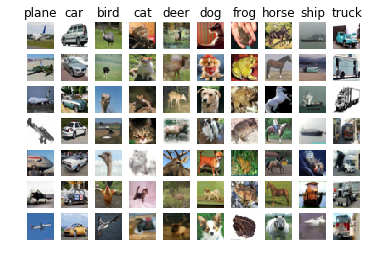

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


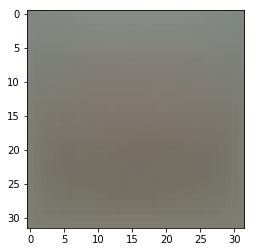

In [10]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [11]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [12]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Весь дальнейший код нужно будет реализовать в файле **cs231n/classifiers/linear_svm.py**. 

Функция `compute_loss_naive` в данном случае уже частично реализована за вас и производит неэффективный подсчёт самого значения loss-а.

In [15]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.401953


Значение `grad`, возаращаемое из функции сейчас состоит из нулей. Реализуйте подсчёт градиента и добавьте его в функцию `svm_loss_naive`.

Для проверки корректности вычисленного градента, можно использовать сравнение с численным градиентом. Код ниже проводит тестирование:

In [16]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 13.781185 analytic: 13.781185, relative error: 1.389519e-11
numerical: -42.685746 analytic: -42.685746, relative error: 3.142829e-12
numerical: -1.024101 analytic: -1.024101, relative error: 2.166088e-10
numerical: -5.954000 analytic: -5.954000, relative error: 4.915398e-11
numerical: 15.104032 analytic: 15.104032, relative error: 7.109999e-12
numerical: 9.981013 analytic: 9.981013, relative error: 5.216086e-11
numerical: 16.770352 analytic: 16.770352, relative error: 1.333871e-11
numerical: 15.018209 analytic: 15.018209, relative error: 6.932462e-12
numerical: 0.683840 analytic: 0.683840, relative error: 9.453688e-10
numerical: 5.910132 analytic: 5.910132, relative error: 1.035599e-11
numerical: 20.398690 analytic: 20.398690, relative error: 3.608587e-12
numerical: 10.956296 analytic: 10.956296, relative error: 4.502155e-11
numerical: -6.023594 analytic: -6.023594, relative error: 2.151442e-11
numerical: -17.388248 analytic: -17.388248, relative error: 5.021089e-12
numerica

** Вопрос №1 **:

Иногда бывает так, что в какой-то момент одно из измерений при сравнении градиентов не будет подностью совпадать. Что может приводить к подобному разбросу? Стоит ли по этому поводу волноваться? Можно ли привести простой пример, в котором сравнение градиентов в одном из измерений сработает неправильно? Как можно повлиять на частоту возникновения подобных граничных эффектов? *Подсказка: SVM loss строго говоря не дифференцируется*

**Ваш ответ:** *впишите сюда.*

Далее нужно реализовать векторизованную версию кода: `svm_loss_vectorized`.

In [19]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.401953e+00 computed in 0.168017s
Vectorized loss: 9.401953e+00 computed in 0.008128s
difference: -0.000000


In [20]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.173061s
Vectorized loss and gradient: computed in 0.007824s
difference: 0.000000


### Stochastic Gradient Descent

Теперь мы умеем эффективно считать выражения для loss-а и его градиента, причём градиент совпадает с численным. Теперь мы готовы к оптимизации loss-а.

Реализуйте функцию `LinearClassifier.train()` в файле `linear_classifier.py`

In [21]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.202679
iteration 100 / 1500: loss 290.816803
iteration 200 / 1500: loss 109.272749
iteration 300 / 1500: loss 43.455908
iteration 400 / 1500: loss 18.684268
iteration 500 / 1500: loss 10.298701
iteration 600 / 1500: loss 7.043952
iteration 700 / 1500: loss 5.971828
iteration 800 / 1500: loss 6.008316
iteration 900 / 1500: loss 5.120155
iteration 1000 / 1500: loss 5.713072
iteration 1100 / 1500: loss 5.298373
iteration 1200 / 1500: loss 5.259679
iteration 1300 / 1500: loss 4.907873
iteration 1400 / 1500: loss 4.907260
That took 12.125838s


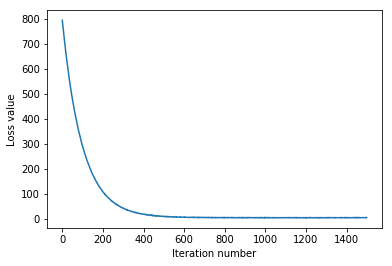

In [22]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

А теперь потребуется реализацию функции `LinearClassifier.predict()`

In [25]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368714
validation accuracy: 0.381000


Подберите значения гиперпараметров: силы регуляризации и скорости обучения

In [43]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-6]
regularization_strengths = [1.2e4, 1.3e4, 1.4e4, 1.5e4, 1.6e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=rate, reg=reg, num_iters=5000)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[rate, reg] = (train_accuracy, val_accuracy)
        
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-06 reg 1.200000e+04 train accuracy: 0.334122 val accuracy: 0.359000
lr 1.000000e-06 reg 1.300000e+04 train accuracy: 0.292755 val accuracy: 0.280000
lr 1.000000e-06 reg 1.400000e+04 train accuracy: 0.317898 val accuracy: 0.318000
lr 1.000000e-06 reg 1.500000e+04 train accuracy: 0.286571 val accuracy: 0.285000
lr 1.000000e-06 reg 1.600000e+04 train accuracy: 0.305939 val accuracy: 0.316000
best validation accuracy achieved during cross-validation: 0.359000


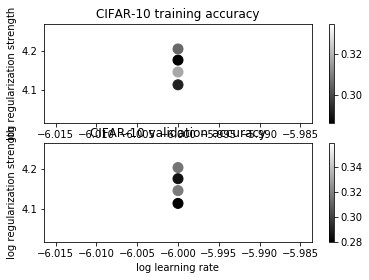

In [44]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [45]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.346000


Осталось визуализировать обученные веса для всех классов

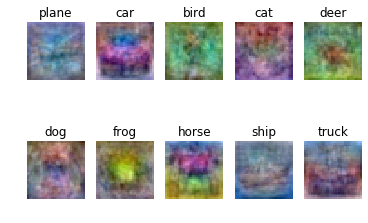

In [46]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# Часть 3. Softmax классификатор

В этом упражнении вы:

- реализуете полностью векторизованную **функцию потерь** для Softmax классификатора
- реализуете полностью векторизованное представление его **аналитического градиента**
- **проверите реализацию** числовым градиентом
- используете валидационное множество **чтобы подобрать параметр learning rate и силу регуляризации**
- **оптимизируете** функцию потерь с помощью **SGD**
- **визуализируете** итоговые полученные веса

Примечание: требуется код, написанный в части 2.

In [47]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Код в этой секции нужно писать в файле **cs231n/classifiers/softmax.py**. 
Для начала реализуйте функцию `softmax_loss_naive`

In [49]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.314059
sanity check: 2.302585


**Вопрос №1**
Почему мы ожидаем значение функции потерь -log(0.1)? Дайте краткий ответ.

**Ваш ответ:** из-за случайной равномерной инициализации весов, значения экспонент (и как следсовательно вероятностей) будут мало отличаться, а значит soft max будет -log(0.1) (10 классов)

Допишите вашу реализацию, чтобы она также возвращала и корректный градиент. Ячейка ниже проверит его на корректность по сравнению с числовым градиентом.

In [51]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.313549 analytic: -2.313549, relative error: 7.977859e-10
numerical: 1.382017 analytic: 1.382017, relative error: 8.210113e-09
numerical: -0.459597 analytic: -0.459597, relative error: 2.049940e-07
numerical: 1.003595 analytic: 1.003595, relative error: 4.840646e-09
numerical: -1.058771 analytic: -1.058771, relative error: 1.921988e-08
numerical: -1.432114 analytic: -1.432114, relative error: 1.167540e-08
numerical: 1.703285 analytic: 1.703285, relative error: 8.873875e-09
numerical: -0.121796 analytic: -0.121796, relative error: 1.865420e-08
numerical: -0.019742 analytic: -0.019742, relative error: 1.175239e-07
numerical: 2.221072 analytic: 2.221072, relative error: 7.038478e-09
numerical: 1.002801 analytic: 1.002801, relative error: 4.172178e-08
numerical: -1.442569 analytic: -1.442569, relative error: 9.057413e-09
numerical: -0.653395 analytic: -0.653395, relative error: 1.571238e-08
numerical: -0.160885 analytic: -0.160885, relative error: 3.399488e-07
numerical: 1.840

Теперь реализуйте функцию `softmax_loss_vectorized` - подсчёт того же самого значения и градиента с использованием векторных операций.

In [56]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.314059e+00 computed in 0.169877s
vectorized loss: 2.314059e+00 computed in 0.007994s
Loss difference: 0.000000
Gradient difference: 0.000000


Используйте вализационное множество для подбора гиперпараметров силы регуляризации и learning rate.

In [61]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6]
regularization_strengths = [1e3, 5e3, 1e4, 5e4, 1e5]

for rate in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=rate, reg=reg, num_iters=1000)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[rate, reg] = (train_accuracy, val_accuracy)
        
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.361898 val accuracy: 0.367000
lr 5.000000e-07 reg 5.000000e+03 train accuracy: 0.372327 val accuracy: 0.378000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.350571 val accuracy: 0.349000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.308265 val accuracy: 0.332000
lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.292000 val accuracy: 0.318000
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.393204 val accuracy: 0.397000
lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.365184 val accuracy: 0.371000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.350143 val accuracy: 0.351000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.284878 val accuracy: 0.296000
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.268612 val accuracy: 0.281000
best validation accuracy achieved during cross-validation: 0.397000


Наконец посчитайте значение accuracy для лучшего классификатора

In [62]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.385000


**Вопрос №2** - да или нет

Возможно ли, что при добавлении нового примера в обучающих данных SVM loss бы не изменился, но Softmax loss при этом бы поменялся?

*Ваш ответ*:

*Ваше объяснение*:

Осталось визуализировать обученные веса для всех классов

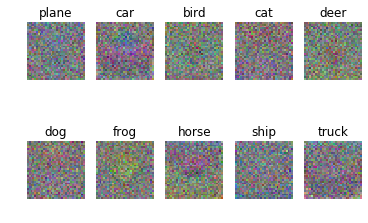

In [63]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])